In [64]:
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
#Importing Libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
from sklearn import metrics


# Reading and fetching the data 

In [66]:
# Read csv file to fetch data
df = pd.read_csv('final_amazon.csv', index_col="date_str_x", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()


,Unnamed: 0,close_value,trend_score,sentiment
date_str_x,,,,
2019-12-27,1821,1869.80,3860,0.353117
2019-12-28,1822,1869.80,753,0.276010
2019-12-29,1823,1869.80,868,0.327622
2019-12-30,1824,1846.89,1498,0.355969
2019-12-31,1825,1847.84,1067,0.345254


In [67]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
df = df[["close_value", "sentiment", "trend_score"]]
df.head()


,close_value,sentiment,trend_score
date_str_x,,,
2015-01-01,310.35,-0.221957,1007
2015-01-02,308.52,0.184688,534
2015-01-03,308.52,0.259859,61
2015-01-04,308.52,0.287238,90
2015-01-05,302.19,0.318348,242


We try to observe the chnages in stock values

In [68]:
# pct change based on Adj close value
df["Pct_change"] = df["close_value"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()


,close_value,sentiment,trend_score,Pct_change
date_str_x,,,,
2015-01-02,308.52,0.184688,534,-0.005897
2015-01-03,308.52,0.259859,61,0.000000
2015-01-04,308.52,0.287238,90,0.000000
2015-01-05,302.19,0.318348,242,-0.020517
2015-01-06,295.29,0.193824,263,-0.022833


# Preparing data for preparation
Generally the stocks might not just fluctuate due to single day tweets hence we try to create input data in such a way to incorporate trends of some of the previous days (3 day window)

In [69]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_sentiment", "X_ts" and y
    X_close = []
    X_sentiment = []
    X_ts = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_sentiment = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_close.append(close)
        X_sentiment.append(ts_sentiment)
        X_ts.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_sentiment,X_ts)), np.array(y).reshape(-1, 1)

In [70]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Close value` column
# Column index 1 is the `Sentiment` column
# Column index 2 is the `Trend score` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

Splitting data into train and test set

In [71]:
# Use 70% of the data for training and the remainder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

Scaling the data:

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


We will now attempt to predict the Close value by making use of both twitter volume and sentiment . The following machine learning models are implemented:

1.Random Forest Regressor

2.Support Vector Regressor

Random Forest Regressor:

In [74]:
# Create the Random Forest regressor instance
model = RandomForestRegressor(n_estimators=1000, max_depth=2, bootstrap=False, min_samples_leaf=1)

# Fit the model
model.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=False, max_depth=2, n_estimators=1000)

In [75]:
# Make some predictions
predicted = model.predict(X_test)
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.0765441095868005
R-squared : 0.8246934658701477


Accuracy of the model:

In [76]:
model.score(X_test,y_test)

0.8246934658701477

In [77]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
date_str_x,,
2018-07-03,1693.96,1613.016741
2018-07-04,1693.96,1613.016741
2018-07-05,1699.73,1613.016741
2018-07-06,1710.63,1613.016741
2018-07-07,1710.63,1613.016741


Visualising performance of our model:

(array([736876., 736938., 736999., 737060., 737119., 737180., 737241.,
        737303., 737364., 737425.]),
 <a list of 10 Text major ticklabel objects>)

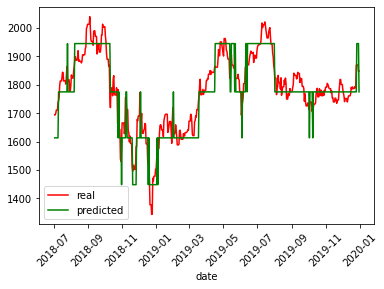

In [78]:
import matplotlib.pyplot as plt
plt.plot(stocks['Real'], color = 'r' , label = 'real')
plt.plot(stocks['Predicted'] , color = 'g' , label = 'predicted')
plt.xlabel('date')
plt.legend()
plt.xticks(rotation = 45)
     

Support Vector Regressor:

In [79]:
from sklearn import svm
model2 = svm.SVR()

# Fit the model
model2.fit(X_train, y_train.ravel())

SVR()

In [80]:
# Make some predictions
predicted = model2.predict(X_test)
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.05575409711963055
R-squared : 0.9069903248858684


Accuracy of the model:

In [81]:
model2.score(X_test,y_test)

0.9069903248858684

In [82]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()


,Real,Predicted
date_str_x,,
2018-07-03,1693.96,1701.991459
2018-07-04,1693.96,1701.096727
2018-07-05,1699.73,1701.917154
2018-07-06,1710.63,1690.457910
2018-07-07,1710.63,1702.116306


Visualising performance of our model:

(array([736876., 736938., 736999., 737060., 737119., 737180., 737241.,
        737303., 737364., 737425.]),
 <a list of 10 Text major ticklabel objects>)

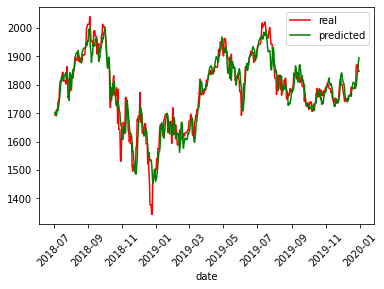

In [83]:
import matplotlib.pyplot as plt
plt.plot(stocks['Real'], color = 'r' , label = 'real')
plt.plot(stocks['Predicted'] , color = 'g' , label = 'predicted')
plt.xlabel('date')
plt.legend()
plt.xticks(rotation = 45)
     